## <center> How to Simulate Correlated Stock Prices using Gaussian Copula <center>

One of the most common stochastic models used to simulate an asset price path is the Geometric Brownian Motion (GMB). However, in many cases finance professionals work on asset portfolios rather than in individual assets. <br>
This methodology describes how to combine Gaussian Copula and GMB to simulate a set of correlated stock prices. 
First let’s define the mathematical concepts that we need.


### Geometric Brownian Motion

Geometric Brownian Motion (GMB) is a stochastic process used to model financial processes subject to random noises such as stock prices.
The stochastic differential equation (SDE) of the GMB is:

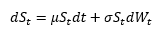

In [16]:
from IPython.display import Image
Image(filename='GMB SDE.PNG')

Where: <p>
S_t is the underlying asset price level at r <p>
μ is the constant mean or drift <p>
σ is the constant volatility and dW_t is the Wiener process (the source of randomness) <p>

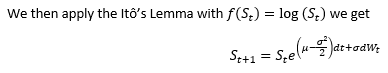

In [17]:
Image(filename='GMB Solution.PNG')

The underlying assumption of a GMB is that the stock returns are normally distributed (the stock prices are then log-normally distributed).

### Copula

Copula is a multivariate cumulative distribution function which describe the dependence between random variables.<p> 
Copula is a statistical model that describes the joint probabilities of a multivariate distribution. <p>
Copulas are often used in quantitative finance to model the tail-risk or returns of a set of correlated distributions. There are many types of copulas which all have different applications. There are many types of copulas which all have different application. The Gaussian Copula will be used in this implementation.

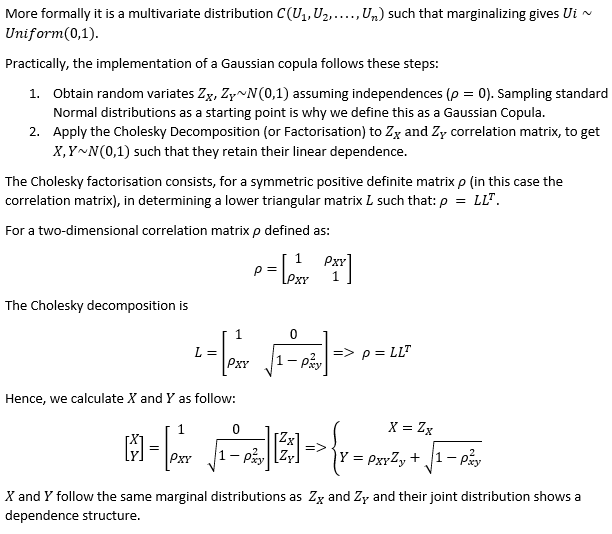

In [18]:
Image(filename='Copula Model.PNG')

### Implementation

The calculation steps are: <p>
    1. Download historical stock prices<br>
    2. Calculate periodic returns of the stocks <br>
    3. Compute the drift and the volatility for each stock <br>
    4. Compute the returns covariance matrix <br>
    5. Decompose the correlation matrix using the Cholesky decomposition <br>
    6. Generate correlated random walks using GMB and correlated random numbers generated using the lower triangle matrix previously calculated

Let's use this method to simulate the prices over 1000 days for a basket of 5 technology companies:  Apple, Amazon, Google, Microsoft and Tesla.
The first step is to download historical prices (5Y).

In [19]:
import numpy as np
import pandas as pd

# Download historical data
data = pd.read_csv(r'C:\Users\veron\OneDrive\Documents\Articles\Copula\Portfolio.csv')

# Set the date column as the dataframe index
data.set_index('Date', inplace = True)

In [20]:
# display the first 5 rows
data.head()

,AAPL,AMZN,GOOG,MSFT,TSLA
Date,,,,,
08/01/2018,43.59,62.34,55.35,88.28,22.43
09/01/2018,43.58,62.63,55.31,88.22,22.25
10/01/2018,43.57,62.72,55.13,87.82,22.32
11/01/2018,43.82,63.83,55.28,88.08,22.53
12/01/2018,44.27,65.26,56.11,89.60,22.41


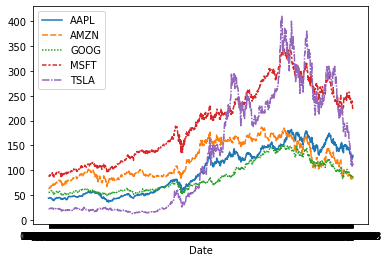

<Figure size 1080x2160 with 0 Axes>

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(data=data)
plt.figure(figsize = (15,30))
plt.show()

In [22]:
# compute returns
returns = data.pct_change()[1:]

# Display the returns
returns.head()

,AAPL,AMZN,GOOG,MSFT,TSLA
Date,,,,,
09/01/2018,-0.000229,0.004652,-0.000723,-0.000680,-0.008025
10/01/2018,-0.000229,0.001437,-0.003254,-0.004534,0.003146
11/01/2018,0.005738,0.017698,0.002721,0.002961,0.009409
12/01/2018,0.010269,0.022403,0.015014,0.017257,-0.005326
16/01/2018,-0.004970,-0.000306,-0.000356,-0.013951,0.011602


In [23]:
# compute the mean returns
drift = returns.mean(axis = 0)

# compute the volatility
vol = returns.std(axis = 0)

# Compute the correlation matrix
corr = returns.corr()

In [24]:
# display correlation matrix 
corr

,AAPL,AMZN,GOOG,MSFT,TSLA
AAPL,1.000000,0.650289,0.697920,0.768558,0.469520
AMZN,0.650289,1.000000,0.686473,0.714355,0.430572
GOOG,0.697920,0.686473,1.000000,0.803048,0.407738
MSFT,0.768558,0.714355,0.803048,1.000000,0.457715
TSLA,0.469520,0.430572,0.407738,0.457715,1.000000


The Cholesky decomposition of the correlation matrix and the lower triangle matrix are obtained using the numpy library:

In [25]:
L = np.linalg.cholesky(corr)

In [26]:
# Display the obtained lower triangle matrix
L

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.65028914, 0.7596868 , 0.        , 0.        , 0.        ],
       [0.69792008, 0.30620914, 0.64741295, 0.        , 0.        ],
       [0.76855845, 0.28244468, 0.27828981, 0.50209331, 0.        ],
       [0.46952013, 0.16486861, 0.0456682 , 0.07485887, 0.86294829]])

The next step is to generate uncorrelated random numbers and then multiply them with the lower triangle matrix to generate correlated variables (dW). These correlated variables are then used to create correlated random walks.

In [27]:
# Function that generates correlated prices for one date
def GMB(stock_prices, number_of_assets, dt, vol, drifts, dW_array, t):
    for i in range(number_of_assets):
        S = stock_prices[i, t-1]
        sigma = vol[i]
        dW = dW_array[i]
        
        stock_prices[i,t] = S * np.exp((drifts[i] - (sigma**2)/2)*dt+sigma*np.sqrt(dt)*dW)
    
    return stock_prices

In [28]:
# Function that generates correlated random walks
def Simulation(stock_prices, number_of_assets, T, vol, drift, L):
    for t in range(1,T):
        
        # simulate all asset prices
        random_array = np.random.standard_normal(number_of_assets)
        dW_array = np.dot(L, random_array)
        
        # define time step
        dt = 1/T

        stock_prices = GMB(stock_prices, number_of_assets, dt, vol, drift, dW_array, t)
    
    return stock_prices


In [29]:
# Get the number of assets
number_of_assets = len(data.columns)

# set the number of simulated prices
T = 1000

# create a stock prices matrix
stock_prices = np.full((number_of_assets, T), 100.0)

In [30]:
# Generate asset paths
asset_paths = Simulation(stock_prices, number_of_assets, T, vol, drift, L)

In [31]:
# create a dataframe
df_asset_paths = pd.DataFrame(asset_paths).T
df_asset_paths.columns = data.columns
df_asset_paths.head()

,AAPL,AMZN,GOOG,MSFT,TSLA
0,100.000000,100.000000,100.000000,100.000000,100.000000
1,100.053088,100.058688,100.037206,100.060732,100.143107
2,99.946880,100.020345,99.931020,99.980992,100.170757
3,99.939877,100.056020,99.915598,100.000405,100.155720
4,99.955462,100.033280,99.932768,99.988038,99.824088


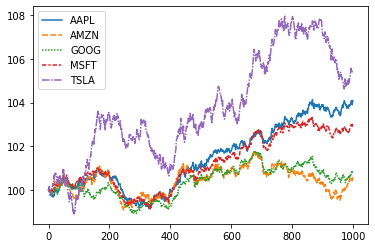

<Figure size 1080x2160 with 0 Axes>

In [32]:
# plot the results
sns.lineplot(data=df_asset_paths)
plt.figure(figsize = (15,30))
plt.show()

### Conclusion

This implementation provides a simple way to simulate correlated asset paths. 
It assumes that stock returns are normally distributed, which not may not always be the case. In reality Kurtosis can be high (>3) which implies a fat-tailed distribution.  A t-student distribution may be appropriate to capture the  higher tail risk. Also skewness can be negative which indicates that losses are larger and less frequent than gains.